In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.manifold import TSNE

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set matplotlib inline for Jupyter
%matplotlib inline
sns.set(style='whitegrid')

In [14]:
# Dataset Class
class MedicalMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
        self.images = []
        self.labels = []

        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)
        return img, label

# Load dataset
data_dir = r'C:\Users\sonke\Desktop\python CA2'
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = MedicalMNISTDataset(root_dir=data_dir, transform=transform)

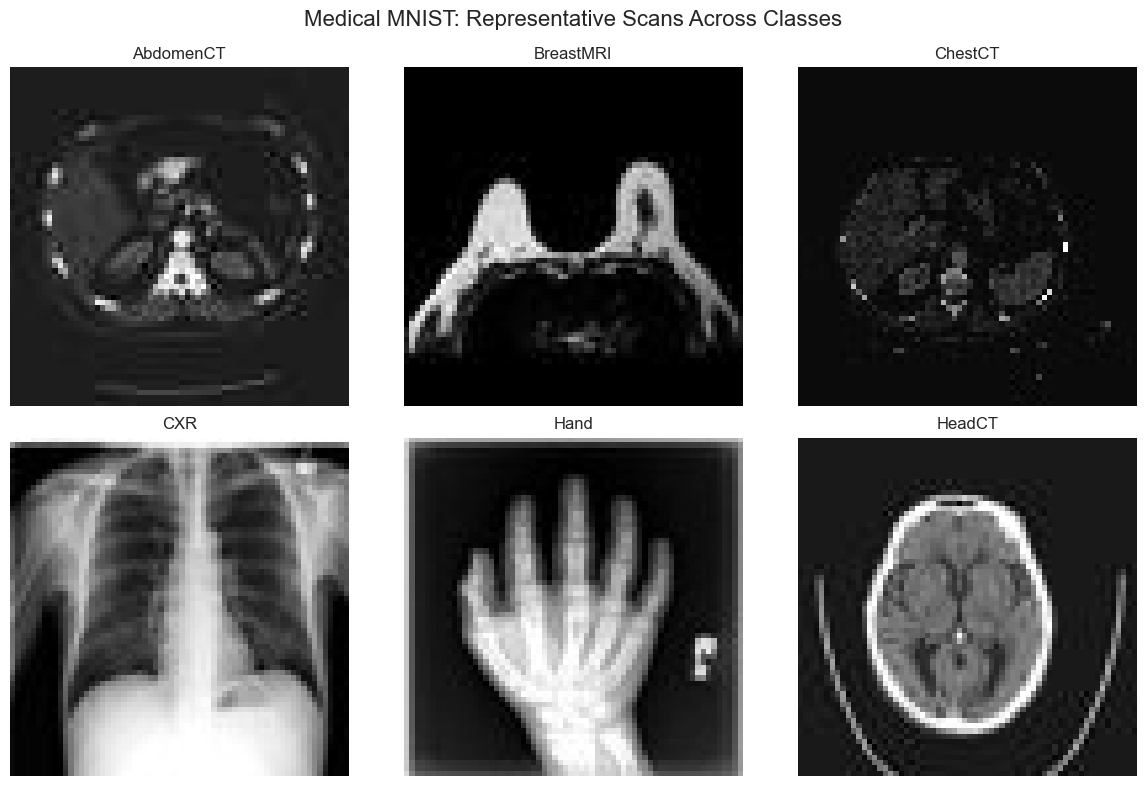

In [15]:
# Visualize one image from each class
classes_to_show = ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']
class_indices = {cls: None for cls in classes_to_show}

# Find the first occurrence of each class
for idx, (img, label) in enumerate(dataset):
    cls = dataset.idx_to_class[label]
    if cls in class_indices and class_indices[cls] is None:
        class_indices[cls] = idx
    if all(val is not None for val in class_indices.values()):
        break

# Plot representative images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Medical MNIST: Representative Scans Across Classes', fontsize=16)
for i, cls in enumerate(classes_to_show):
    ax = axes[i // 3, i % 3]  # 2 rows, 3 cols
    idx = class_indices[cls]
    img, label = dataset[idx]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(cls, fontsize=12)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [16]:
# Model with Dropout
class ProtoNetCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ProtoNetCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 8 * 8, 64)
        )

    def forward(self, x):
        return self.encoder(x)

In [17]:
# Baseline CNN
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(BaselineCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.classifier = nn.Linear(128 * 8 * 8, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [18]:
# Helper Functions
def compute_prototypes(embeddings, labels, n_way):
    prototypes = []
    for c in range(n_way):
        class_samples = embeddings[labels == c]
        prototype = class_samples.mean(dim=0)
        prototypes.append(prototype)
    return torch.stack(prototypes)

def create_episode(dataset, n_way, k_shot, q_query):
    if isinstance(dataset, torch.utils.data.Subset):
        full_dataset = dataset.dataset
        subset_indices = dataset.indices
        labels = np.array(full_dataset.labels)[subset_indices]
    else:
        full_dataset = dataset
        labels = np.array(dataset.labels)
    
    unique_classes = np.unique(labels)
    selected_classes = np.random.choice(unique_classes, n_way, replace=False)
    label_map = {old_label: new_label for new_label, old_label in enumerate(selected_classes)}
    
    support_set, query_set, support_labels, query_labels = [], [], [], []
    for c in selected_classes:
        class_indices = [i for i, lbl in enumerate(labels) if lbl == c]
        indices = np.random.permutation(class_indices)
        support_indices = indices[:k_shot]
        query_indices = indices[k_shot:k_shot + q_query]
        
        if isinstance(dataset, torch.utils.data.Subset):
            support_indices = [subset_indices[idx] for idx in support_indices]
            query_indices = [subset_indices[idx] for idx in query_indices]
        
        for idx in support_indices:
            img, lbl = full_dataset[idx]
            support_set.append(img)
            support_labels.append(label_map[lbl])
        for idx in query_indices:
            img, lbl = full_dataset[idx]
            query_set.append(img)
            query_labels.append(label_map[lbl])
    
    return (torch.stack(support_set), torch.tensor(support_labels),
            torch.stack(query_set), torch.tensor(query_labels))

In [19]:
# Training Function (Simplified)
def train_protonet(model, dataset, n_way=5, k_shot=5, q_query=5, epochs=20, lr=0.001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    
    for epoch in tqdm(range(epochs), desc=f"Training (n_way={n_way}, k_shot={k_shot})"):
        model.train()
        optimizer.zero_grad()
        support_set, support_labels, query_set, query_labels = create_episode(dataset, n_way, k_shot, q_query)
        support_set, support_labels = support_set.to(device), support_labels.to(device)
        query_set, query_labels = query_set.to(device), query_labels.to(device)
        
        support_embeddings = model(support_set)
        query_embeddings = model(query_set)
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way)
        distances = torch.cdist(query_embeddings, prototypes)
        
        loss = criterion(-distances, query_labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), losses, label='Training Loss', color='blue')
    plt.title(f'Few-Shot Learning Progress: {n_way}-Way {k_shot}-Shot', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
    return losses

In [32]:
# Baseline Training (Simplified)
def train_baseline(model, train_loader, epochs=10, lr=0.001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    
    for epoch in tqdm(range(epochs), desc="Baseline Training"):
        model.train()
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {losses[-1]:.4f}")
    return losses

In [26]:
# Evaluation Function with t-SNE
def evaluate_protonet(model, dataset, n_way=5, k_shot=5, q_query=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    model.eval()
    all_preds, all_labels, all_embeddings = [], [], []
    
    num_episodes = 3  # Reduced for speed
    for _ in range(num_episodes):
        with torch.no_grad():
            support_set, support_labels, query_set, query_labels = create_episode(dataset, n_way, k_shot, q_query)
            support_set, support_labels = support_set.to(device), support_labels.to(device)
            query_set, query_labels = query_set.to(device), query_labels.to(device)
            
            support_embeddings = model(support_set)
            query_embeddings = model(query_set)
            prototypes = compute_prototypes(support_embeddings, support_labels, n_way)
            distances = torch.cdist(query_embeddings, prototypes)
            
            predictions = distances.argmin(dim=1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(query_labels.cpu().numpy())
            all_embeddings.extend(query_embeddings.cpu().numpy())
    
    accuracy = np.mean([p == l for p, l in zip(all_preds, all_labels)])
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_way), yticklabels=range(n_way))
    plt.title(f'Few-Shot Classification Performance: {n_way}-Way', fontsize=16)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.show()

    # t-SNE Visualization
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(np.array(all_embeddings))
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=all_labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Class')
    plt.title('Embedding Space of Few-Shot Medical Predictions', fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.show()

Baseline Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0020
Epoch [10/10], Loss: 0.0038
Baseline CNN Accuracy: 0.9987

Training Prototypical Network...


Training (n_way=5, k_shot=5):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.0138
Epoch [10/20], Loss: 0.0000
Epoch [15/20], Loss: 0.0000
Epoch [20/20], Loss: 0.1159


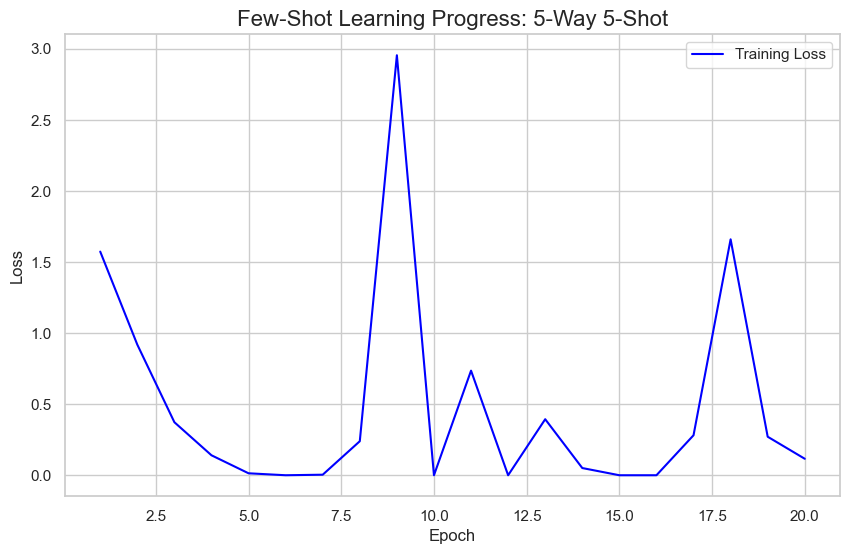


Evaluating on test set...
Accuracy: 0.9600, Precision: 0.9617, Recall: 0.9600, F1-Score: 0.9604


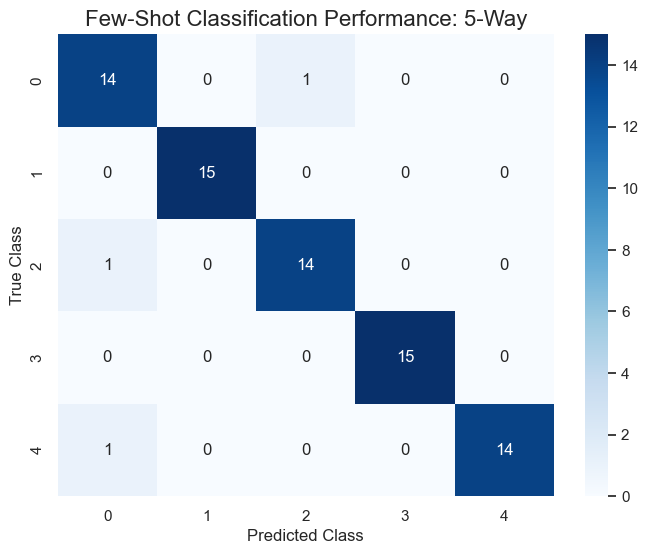

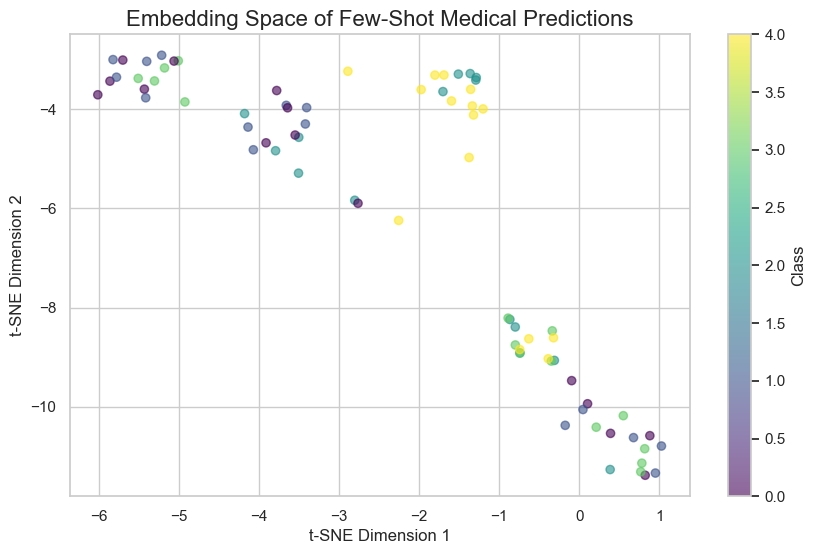

In [33]:
# Main Execution
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Baseline Comparison
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
baseline_model = BaselineCNN(num_classes=6)
baseline_losses = train_baseline(baseline_model, train_loader, epochs=10)
baseline_model.eval()
baseline_preds, baseline_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = baseline_model(images)
        preds = outputs.argmax(dim=1)
        baseline_preds.extend(preds.cpu().numpy())
        baseline_labels.extend(labels.cpu().numpy())
baseline_accuracy = np.mean([p == l for p, l in zip(baseline_preds, baseline_labels)])
print(f"Baseline CNN Accuracy: {baseline_accuracy:.4f}")

# Few-Shot Training and Evaluation
print("\nTraining Prototypical Network...")
model = ProtoNetCNN(dropout_rate=0.3)
train_protonet(model, train_dataset, n_way=5, k_shot=5, q_query=5, epochs=20)
print("\nEvaluating on test set...")
evaluate_protonet(model, test_dataset, n_way=5, k_shot=5, q_query=5)